In [8]:
import pandas as pd

# 导入数据集
data = pd.read_csv('./dataset/item_comments.csv')

# 创建情感标签映射字典
label_mapping = {'正面': 1, '负面': 0}

# 对情感标签进行映射
data['label'] = data['label'].map(label_mapping)

# 打印数据集
data.head()

,evaluation,label
0,用了一段时间，感觉还不错，可以,1
1,电视非常好，已经是家里的第二台了。第一天下单，第二天就到本地了，可是物流的人说车坏了，一直催...,1
2,电视比想象中的大好多，画面也很清晰，系统很智能，更多功能还在摸索中,1
3,不错,1
4,用了这么多天了，感觉还不错。夏普的牌子还是比较可靠。希望以后比较耐用，现在是考量质量的时候。,1


In [10]:
import jieba

# 加载停用词表
stopwords = pd.read_csv('./stopWords/stop_words.txt', index_col=False, quoting=3, sep="\t", names=['stopword'], encoding='utf-8')
# 转换为列表
stopwords_list = stopwords['stopword'].tolist()  

def preprocess_text(text):
    # 分词
    seg_list = jieba.cut(text)
    # 去除停用词
    filtered_words = [word for word in seg_list if word not in stopwords_list]
    # 返回处理后的分词结果
    return ' '.join(filtered_words)

# 对text列进行分词和停用词过滤
data['evaluation'] = data['evaluation'].apply(preprocess_text)

# 打印数据集
print(data)

                                             evaluation  label
0                     用     一段时间     感觉   还   不错     可以      1
1     电视   非常   好     已经     家里     第二台       第一天   ...      1
2     电视   比   想象   中     大   好多     画面   也   很   清晰...      1
3                                                    不错      1
4     用     这么   多天       感觉   还   不错     夏普     牌子 ...      1
...                                                 ...    ...
4278  一般     差强人意     还   弄     点   不   愉快     投诉   ...      0
4279  屏幕   拐角   明显   暗     图像   不到   边     工程师   上门 ...      0
4280  一分     不想   给     京东   这次   让   我   太   失望    ...      0
4281  新   电视   买   回家   不到   十多天     底座   支架   因   质...      0
4282  一般般     这个   价位   也   不会   抱太多     期望     比   ...      0

[4283 rows x 2 columns]


In [16]:
# 导入情感分析所需的库
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

# 划分训练集和测试集
X = data['evaluation']  # 特征
y = data['label']  # 标签
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征提取
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# 建立模型
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# 模型评估
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("模型准确率：", accuracy)
print("分类报告：\n", report)

模型准确率： 0.8751458576429405
分类报告：
               precision    recall  f1-score   support

           0       0.83      0.96      0.89       448
           1       0.95      0.78      0.86       409

    accuracy                           0.88       857
   macro avg       0.89      0.87      0.87       857
weighted avg       0.89      0.88      0.87       857



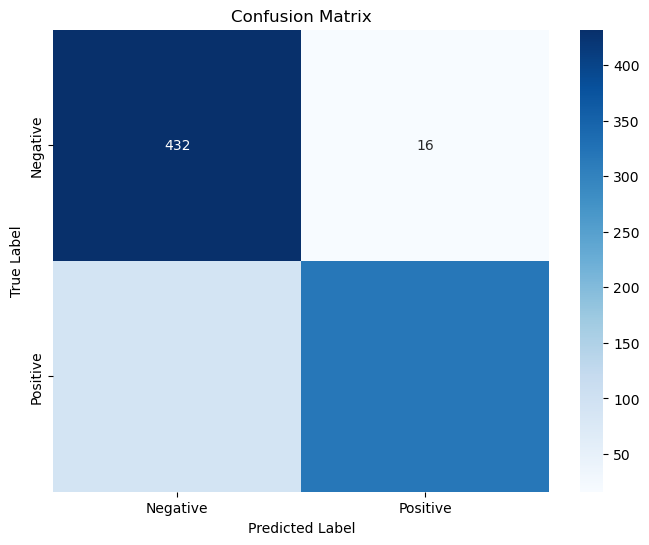

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV

# 设置不同的 alpha 值作为参数候选
alpha_values = [0.1, 0.5, 1.0, 1.5, 2.0]

# 创建参数网格
param_grid = {'alpha': alpha_values}

# 使用 GridSearchCV 进行交叉验证
advanced_model = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
advanced_model.fit(X_train_vec, y_train)

# 输出最佳参数
print("Best alpha value:", advanced_model.best_params_['alpha'])

# 输出最佳模型的准确率
print("Best model accuracy:", advanced_model.best_score_)

y_pred_advanced = advanced_model.predict(X_test_vec)
accuracy_advanced = accuracy_score(y_test, y_pred_advanced)
report_advanced = classification_report(y_test, y_pred_advanced)

print("模型准确率：", accuracy_advanced)
print("分类报告：\n", report_advanced)

Best alpha value: 0.1
Best model accuracy: 0.9141920793343405
模型准确率： 0.8996499416569428
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.95      0.91       448
           1       0.94      0.84      0.89       409

    accuracy                           0.90       857
   macro avg       0.90      0.90      0.90       857
weighted avg       0.90      0.90      0.90       857



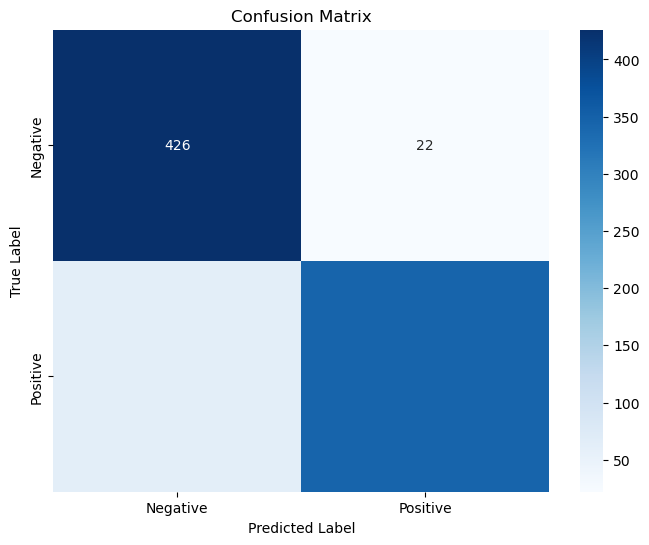

In [19]:
# 计算混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred_advanced)

# 绘制混淆矩阵热力图
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

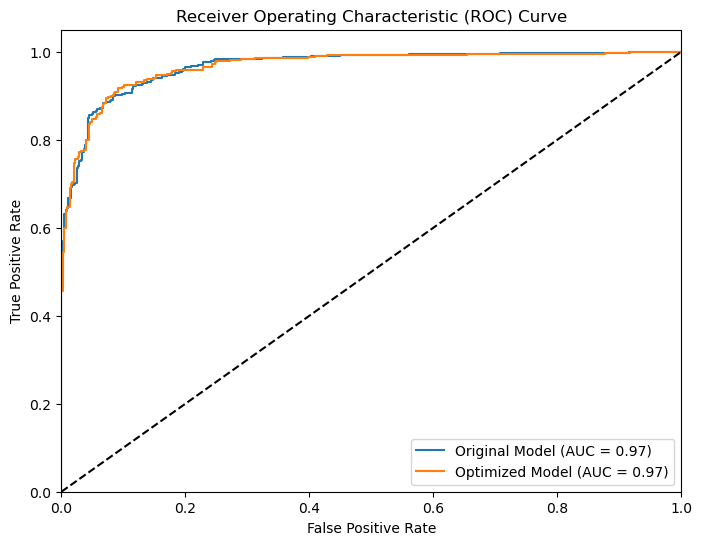

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 原始模型的 ROC 曲线
y_pred_proba_orig = model.predict_proba(X_test_vec)[:,1]
fpr_orig, tpr_orig, thresholds_orig = roc_curve(y_test, y_pred_proba_orig)
roc_auc_orig = roc_auc_score(y_test, y_pred_proba_orig)

# 优化后模型的 ROC 曲线
# 在这里假设你已经优化了模型，并且得到了优化后的模型和特征表示
# 请将下面的代码替换为你实际优化后模型的预测概率和评分
y_pred_proba_advanced = advanced_model.predict_proba(X_test_vec)[:,1]
fpr_opt, tpr_opt, thresholds_opt = roc_curve(y_test, y_pred_proba_advanced)
roc_auc_opt = roc_auc_score(y_test, y_pred_proba_advanced)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label='Original Model (AUC = %0.2f)' % roc_auc_orig)
plt.plot(fpr_opt, tpr_opt, label='Optimized Model (AUC = %0.2f)' % roc_auc_opt)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()